# MSBA SMA Assignment 
Emilio Cabrera (eac4622), Conoly Cravens (mcc4443), Ally McNulty (agm3734),  Chaitra Setty (cs63687), Allie Touchstone (awt529)




## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns
import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('train.csv')
data.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


## Part I: Find predictors of influence
### Check if you should use all variables
We checked to see if we should use all the variables by looking at the correlations of columns. Since the dataset had the same variables for both A and B, we looked at the correlations of the A variables (verified with the B variables). 

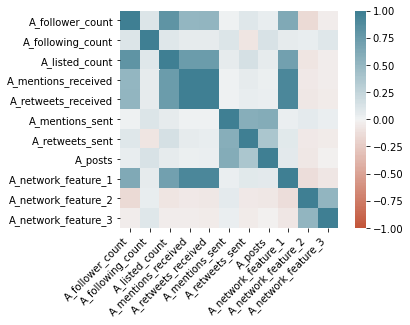

In [3]:
# check correlation of columns
a = data.iloc[:,1:12]
corr = a.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

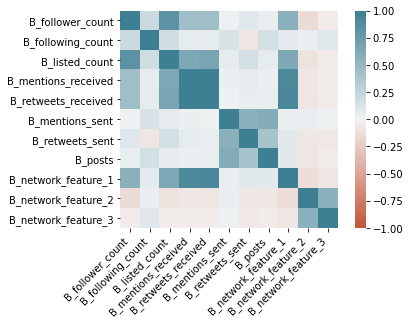

In [4]:
# test the correlation
b = data.iloc[:,12:]
corr = b.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The correlations of the variables are the same for both A and B. As we can see in the correlation matrix, there are some variables that are highly correlated. These columns capture the same information. We decided to drop the following two variables (4 columns) to account for this:

* A_mentions_received & B_mentions_received
* A_network_feature_1 & B_network_feature_1

In [5]:
#dropped columns with low correlation
df = data.drop(['A_mentions_received','A_network_feature_1','B_mentions_received','B_network_feature_1'],axis = 1)
df.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.100503,0.100503,0.100503,0.362150,166.500000,11355.000000,34463,29808,1689,3.984029,8.204331,0.332423,6.988815,75.530303,1916.893939
1,0,21591,1179,228,25.798292,5.709329,1.111159,5.176620,18.442971,1330.366048,39262,848,1610,8.943607,3.227677,0.564343,1.070321,132.030675,2931.515337
2,0,7310,1215,101,9.556347,5.361519,0.591206,3.589718,68.927835,5999.896907,3622,482,206,0.354379,0.603202,0.100503,0.603202,10.333333,277.333333
3,0,20,7,2,0.277306,1.331508,0.100503,2.830627,2.000000,96.166667,19562,17637,278,390.293681,27.552040,7.167557,32.101906,23.469296,1395.845634
4,1,45589,862,2641,36.998884,27.881768,3.333492,23.861282,127.404293,2833.847943,7554,1711,181,3.581661,6.764657,1.119727,4.563246,48.500000,1993.627907


### Transform and normalize all data so that all values are between 0 and 1
We decided a transformation of (A-B) led to a more interpretable model. 

In [6]:
#normalized the data
norm_df = pd.DataFrame(df.iloc[:,1:10].values - df.iloc[:,10:19].values)
norm_df.columns = ['A-B_follower_count','A-B_following_count','A-B_listed_count','A-B_retweets_received','A-B_mentions_sent',
              'A-B_retweets_sent','A-B_posts','A-B_network_feature_2','A-B_network_feature_3']
norm_df = norm_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
x = norm_df
y= data['Choice']

### Build a Model

In [7]:
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [8]:
# logistic regression
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.611864
         Iterations 7
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.117      
Dependent Variable:    Choice             AIC:                5065.8765  
Date:                  2022-02-14 22:10   BIC:                5122.7999  
No. Observations:      4125               Log-Likelihood:     -2523.9    
Df Model:              8                  LL-Null:            -2857.8    
Df Residuals:          4116               LLR p-value:        6.0691e-139
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        7.0000                                            
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------
A-B_follower_count     13.4310   2.2296 

In [9]:
clf = LogisticRegression(penalty='none',fit_intercept=False)
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

#### Accuracy Metrics

In [10]:
print("Training Accuracy :", clf.score(x_train, y_train))
print("Testing Accuracy :", clf.score(x_test, y_test))

Training Accuracy : 0.7105454545454546
Testing Accuracy : 0.7069090909090909


#### Confusion Metrics

[Text(0, 0.5, 'B'), Text(0, 1.5, 'A')]

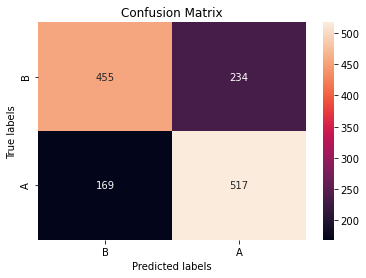

In [11]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['B', 'A']); ax.yaxis.set_ticklabels(['B', 'A'])

#### Classification Report

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       689
           1       0.69      0.75      0.72       686

    accuracy                           0.71      1375
   macro avg       0.71      0.71      0.71      1375
weighted avg       0.71      0.71      0.71      1375



#### ROC Value

In [13]:
print("Area Under the Curve:", roc_auc_score(y_test, y_pred))

Area Under the Curve: 0.7070108366796855


### Important Features
Looking at the result summary from before, we determined the following variables were statistically signifigant according to their p-value:

* A-B_follower_count
* A-B_listed_count
* A-B_retweets_received
* A-B_mentions_sent
* A-B_retweets_sent
* A-B_network_feature_3

We then re-ran a logistic regrssion on those features.

In [14]:
# selected the important features and ran another logistic regression
cols = ['A-B_follower_count','A-B_listed_count','A-B_retweets_received','A-B_mentions_sent','A-B_retweets_sent','A-B_network_feature_3']
x_train2=x_train[cols]
x_test2=x_test[cols]

logit_model=sm.Logit(y_train,x_train2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.612740
         Iterations 7
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.116      
Dependent Variable:    Choice             AIC:                5067.1062  
Date:                  2022-02-14 22:10   BIC:                5105.0551  
No. Observations:      4125               Log-Likelihood:     -2527.6    
Df Model:              5                  LL-Null:            -2857.8    
Df Residuals:          4119               LLR p-value:        1.6333e-140
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        7.0000                                            
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------
A-B_follower_count     13.2665   2.1756 

In [15]:
clf2 = LogisticRegression(penalty='none',fit_intercept=False)
clf2.fit(x_train2,y_train)

y_pred = clf2.predict(x_test2)

#### Accuracy

In [16]:
print("Training Accuracy :", clf2.score(x_train2, y_train))
print("Testing Accuracy :", clf2.score(x_test2, y_test))

Training Accuracy : 0.7117575757575758
Testing Accuracy : 0.7156363636363636


#### Confusion Matrix

[Text(0, 0.5, 'B'), Text(0, 1.5, 'A')]

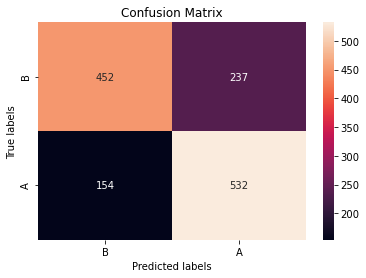

In [17]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['B', 'A']); ax.yaxis.set_ticklabels(['B', 'A'])

### Comparing the Models

The accuracy score with all the features is 71.1% for the training set and 70.7% for the test set. The accuracy score with the most important features is 71.2% for the training set and 71.6% for the test set. A business can use these results to understand the most import features and the impact of each predictor based on the coefficients. For example, with every one unit increase in the predictor, the A-B_listed_count changes by 50.  

### Financial Implications
First, we took the test data and added in the predicted value as well. 

In [18]:
test_indices = y_test.index.tolist()

In [19]:
test_data = data.loc[test_indices,:]
test_data['y_pred'] = y_pred
test_data.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,y_pred
1433,1,366460,466,3381,1167.896930,415.263914,49.918633,8.061557,82.535177,3450,...,5103,150.340456,68.117366,5.480349,0.100503,71.879274,568,205.883275,9580.395470,1
861,1,3166413,276,603,1253.345429,980.120926,12.963425,2.380018,100.537797,4801,...,16,2.215723,0.538122,0.100503,0.100503,0.362150,10,91.900000,2778.900000,1
4944,1,1404323,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,...,165,7.362302,0.100503,4.031142,0.860755,2.563721,21,109.695652,5559.869565,1
3567,0,362,183,9,2.127477,1.860517,0.362150,0.100503,2.321538,8,...,713,21.100497,6.218271,0.885443,0.100503,0.362150,85,78.333333,3680.701149,0
15,1,48711,22845,932,61.924804,18.578901,0.100503,0.100503,0.100503,229,...,29,2.292465,0.312366,5.135358,2.032459,4.423156,11,192.363636,3855.727273,0


#### Baseline Profit

Baseline model is we pay both A & B to tweet once. 

If an influencer tweets once, there is a 0.01% chance that his/her followers will buy one unit of a product. Assume the retailer has a profit margin of \$10 per unit, and that one customer can buy only one unit.

In [20]:
def returns(row):
    choice = row['Choice']
    if choice == 1:
        # Then A is the influencer
        followers = row['A_follower_count']
    else:
        # Then B is the influencer
        followers = row['B_follower_count']
  
    revenue = 0.0001 * followers * 10
    cost = 10
    
    return (revenue-cost)

In [21]:
baseline_profit = sum(test_data.apply(returns, axis=1))

In [22]:
print('Baseline Profits would be', '${:,.2f}'.format(baseline_profit))

Baseline Profits would be $1,302,025.50


#### With our Model
Using our model, we will only pay one person to tweet twice. 

If an influencer tweets twice, the overall buying probability will be 0.015%. Again, it is safe to assume the retailer has a profit margin of \$10 per unit, and that one customer can buy only one unit.

In [23]:
def returns_new(row):
    prediction = row['y_pred']
    choice = row['Choice']
    
    if prediction == choice:
        if choice == 1:
            # Then A is the influencer
            followers = row['A_follower_count']
            
        else:
            # Then B is the influencer
            followers = row['B_follower_count']
            
        revenue = 0.00015 * followers * 10
    else:
        revenue = 0
    
    cost = 10
    
    return (revenue - cost)

In [24]:
model_profit = sum(test_data.apply(returns_new, axis=1))

In [25]:
print('Our model would profit', '${:,.2f}'.format(model_profit))

Our model would profit $1,553,055.21


In [26]:
print('Giving us a lift of', '${:,.2f}'.format(model_profit - baseline_profit))

Giving us a lift of $251,029.72


#### Life with Perfect Model
A perfect model would predict which person is the influencer every time and then the overall buying probability will be 0.015% of every influencer's followers. 

In [27]:
def returns_perfect(row):
    choice = row['Choice']
    
    if choice == 1:
        # Then A is the influencer
        followers = row['A_follower_count']
    
    else:
        # Then B is the influencer
        followers = row['B_follower_count']
    
    revenue = 0.00015 * followers * 10
    
    cost = 10
    
    return (revenue-cost)

In [28]:
perfect_profit = sum(test_data.apply(returns_perfect, axis=1))

In [29]:
print('Now, a perfect model would profit', '${:,.2f}'.format(perfect_profit))

Now, a perfect model would profit $1,959,913.24


In [30]:
print('Which gives a lift over the baseline of', '${:,.2f}'.format(perfect_profit - baseline_profit))

Which gives a lift over the baseline of $657,887.75


In [31]:
print('Or a lift over our model of', '${:,.2f}'.format(perfect_profit - model_profit))

Or a lift over our model of $406,858.03


## Part II: Finding influencers from Twitter 
#### Scraping the data

In [61]:
# # data2 reads in twitter API info 


# import pandas as pd
  
# data = pd.read_csv('data2.csv',header=None)
# data= data[0].to_list()

In [33]:
# with open('data2.csv', 'r') as file:
#     data = file.read().split('\n')
# data

In [34]:
# # API keys for twitter
# consumer_key = data[0]
# consumer_secret = data[1]
# access_key = data[2]
# access_secret = data[3]

In [35]:
# auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
# auth.set_access_token(access_key,access_secret)
# api = tweepy.API(auth,wait_on_rate_limit = True)

In [36]:
# tweets = pd.DataFrame(columns = ['tweet type','A_handle','A_follower_count','A_following_count','A_listed_count','A_posts',
#                                  'A_network_feature_1','A_network_feature_2','A_network_feature_3',
#                                  'B_handle','B_follower_count','B_following_count','B_listed_count','B_posts',
#                                  'B_network_feature_1','B_network_feature_2','B_network_feature_3'])

In [37]:
# #establish count of 5000 tweets and define #SuperBowl as the twitter search criteria 
# tweets_first = []
# text_query = '#SuperBowl'
# count = 5000

In [38]:
# for tweet in tweepy.Cursor(api.search_tweets,
#                            q=text_query,
#                            count=100, # number of results per page
#                            result_type="recent",
#                            include_entities=True).items(count): # total number of results 5000
#     try:
#         tweets_first.append(tweet)  
#         handle = tweet._json['user']['screen_name']
#         if tweet.text[:2] == 'RT': # note if it is a retweet or an original tweet
#             rt_handle = tweet._json['retweeted_status']['user']['screen_name']
#             rt_followers = tweet._json['retweeted_status']['user']['followers_count']
#             rt_following = tweet._json['retweeted_status']['user']['friends_count']
#             rt_listed = tweet._json['retweeted_status']['user']['listed_count']
#             rt_posts = tweet._json['retweeted_status']['user']['statuses_count']
#             content = 'RT'
#         elif False:
#             # it is not a retweet or a tweet so just pass it 
#             pass
#         else:
#             rt_handle = handle
#             content = 'Tweet' # if it is not a retweet or pass it is a tweet
#         followers = tweet._json['user']['followers_count']
#         following = tweet._json['user']['friends_count']
#         listed = tweet._json['user']['listed_count']
#         posts = tweet._json['user']['statuses_count']

#         tweets = tweets.append(pd.Series({'tweet type':content,'A_handle':handle,'A_follower_count':followers,
#                                           'A_following_count':following,'A_listed_count':listed,'A_posts':posts,
#                                           'B_handle':rt_handle,'B_follower_count':rt_followers,
#                                           'B_following_count':rt_following,'B_listed_count':rt_listed,
#                                           'B_posts':rt_posts}), ignore_index = True)#establish dictionary dataframe to store information 
#     except:
#         continue

# tweets.head()

In [39]:
# len(tweets)#check the number of tweets pulled

In [40]:
# pd.DataFrame(tweets).to_csv('tweets_superbowl2.csv')#convert to dataframe

In [41]:
# files.download('tweets_superbowl2.csv')

#### Analysis

In [42]:
import pandas as pd
tweets=pd.read_csv('tweets_superbowl2.csv',index_col=0)

In [43]:
tweets

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,B_follower_count,B_following_count,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,RT,RamsHouse,300,214,1,7791,NaN,NaN,NaN,ArashMarkazi,122863,2296,2935,103421,NaN,NaN,NaN
1,RT,CDJ15894385,1444,5004,3,96479,NaN,NaN,NaN,RamsNFL,1060485,512,6389,59603,NaN,NaN,NaN
2,RT,pirker_josef,68,208,0,332,NaN,NaN,NaN,KreeptoKiid,1147,3754,2,4586,NaN,NaN,NaN
3,Tweet,KushlifeDFS,1193,4987,12,8242,NaN,NaN,NaN,KushlifeDFS,1147,3754,2,4586,NaN,NaN,NaN
4,Tweet,ShakiraPaye,2101,490,9,18504,NaN,NaN,NaN,ShakiraPaye,1147,3754,2,4586,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,RT,MattStaffordQB1,981,234,4,73414,NaN,NaN,NaN,__Knucklehead_,269,300,2,428,NaN,NaN,NaN
4996,Tweet,Simon_Says_Rain,533,2732,34,45792,NaN,NaN,NaN,Simon_Says_Rain,269,300,2,428,NaN,NaN,NaN
4997,Tweet,CrashKoeck,10157,893,59,34286,NaN,NaN,NaN,CrashKoeck,269,300,2,428,NaN,NaN,NaN
4998,RT,stagescreen60,5530,5474,80,51275,NaN,NaN,NaN,RanesHook,3340,4985,67,20288,NaN,NaN,NaN


#### Calculate the degree, betweenness and closeness of each node in the above network. 
We generated the Degree, Betweenness Centrality, and Closeness Centrality from NodeXL and read in the measures.

In [44]:
measures=pd.read_csv('measures2.csv')
measures

,Vertex,Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,SNFonNBC,207,794335.41160,0.119781,0.275050
1,RamsNFL,227,636610.33140,0.114737,0.139338
2,Judge99_SZN,4,158700.71280,0.114197,0.057580
3,R1a9y9j2,6,59166.88424,0.110218,0.073893
4,TLegix,8,68872.81429,0.109753,0.075902
...,...,...,...,...,...
4346,anfernyyyy,2,0.00000,0.000000,0.000000
4347,thaismayc,2,0.00000,0.000000,0.000000
4348,TheMusiqBureau,2,0.00000,0.000000,0.000000
4349,heygechete,2,0.00000,0.000000,0.000000


#### Using the results from Part I, create a list of top 10 influencers from the tweets.

First, we then needed to match the metrics calcualted above to the three 'network features' we used in the logistic regression model in part 1. We need to do this for both the 'A' person and the 'B' person. 

* A_network_feature_1 = Degree
* A_network_feature_2 = Betweenness Centrality
* A_network_feature_3 = Closeness Centrality

In [45]:
#merge measures with tweets for A_handles first
tweets_with_measures=tweets.merge(measures,how='left',left_on='A_handle',right_on='Vertex')
tweets_with_measures.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,...,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Vertex,Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,RT,RamsHouse,300,214,1,7791,NaN,NaN,NaN,ArashMarkazi,...,2935,103421,NaN,NaN,NaN,RamsHouse,4,1427.174496,0.079758,0.000788
1,RT,CDJ15894385,1444,5004,3,96479,NaN,NaN,NaN,RamsNFL,...,6389,59603,NaN,NaN,NaN,CDJ15894385,1,0.000000,0.089611,0.008392
2,RT,pirker_josef,68,208,0,332,NaN,NaN,NaN,KreeptoKiid,...,2,4586,NaN,NaN,NaN,pirker_josef,1,0.000000,0.001502,0.000000
3,Tweet,KushlifeDFS,1193,4987,12,8242,NaN,NaN,NaN,KushlifeDFS,...,2,4586,NaN,NaN,NaN,KushlifeDFS,2,0.000000,0.000000,0.000000
4,Tweet,ShakiraPaye,2101,490,9,18504,NaN,NaN,NaN,ShakiraPaye,...,2,4586,NaN,NaN,NaN,ShakiraPaye,2,0.000000,0.000000,0.000000


In [46]:
#move the A_handle measures to the A_network_feature columns
tweets_with_measures['A_network_feature_1']=tweets_with_measures['Degree']
tweets_with_measures['A_network_feature_2']=tweets_with_measures['Betweenness Centrality']
tweets_with_measures['A_network_feature_3']=tweets_with_measures['Closeness Centrality']
tweets_with_measures.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,...,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Vertex,Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,RT,RamsHouse,300,214,1,7791,4,1427.174496,0.079758,ArashMarkazi,...,2935,103421,NaN,NaN,NaN,RamsHouse,4,1427.174496,0.079758,0.000788
1,RT,CDJ15894385,1444,5004,3,96479,1,0.000000,0.089611,RamsNFL,...,6389,59603,NaN,NaN,NaN,CDJ15894385,1,0.000000,0.089611,0.008392
2,RT,pirker_josef,68,208,0,332,1,0.000000,0.001502,KreeptoKiid,...,2,4586,NaN,NaN,NaN,pirker_josef,1,0.000000,0.001502,0.000000
3,Tweet,KushlifeDFS,1193,4987,12,8242,2,0.000000,0.000000,KushlifeDFS,...,2,4586,NaN,NaN,NaN,KushlifeDFS,2,0.000000,0.000000,0.000000
4,Tweet,ShakiraPaye,2101,490,9,18504,2,0.000000,0.000000,ShakiraPaye,...,2,4586,NaN,NaN,NaN,ShakiraPaye,2,0.000000,0.000000,0.000000


In [47]:
#drop extra columns
tweets_with_measures.drop(['Degree','Betweenness Centrality','Closeness Centrality','Eigenvector Centrality'],axis=1,inplace=True)

In [48]:
tweets_with_measures.drop(['Vertex'],axis=1,inplace=True)

In [49]:
tweets_with_measures.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,B_follower_count,B_following_count,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,RT,RamsHouse,300,214,1,7791,4,1427.174496,0.079758,ArashMarkazi,122863,2296,2935,103421,NaN,NaN,NaN
1,RT,CDJ15894385,1444,5004,3,96479,1,0.000000,0.089611,RamsNFL,1060485,512,6389,59603,NaN,NaN,NaN
2,RT,pirker_josef,68,208,0,332,1,0.000000,0.001502,KreeptoKiid,1147,3754,2,4586,NaN,NaN,NaN
3,Tweet,KushlifeDFS,1193,4987,12,8242,2,0.000000,0.000000,KushlifeDFS,1147,3754,2,4586,NaN,NaN,NaN
4,Tweet,ShakiraPaye,2101,490,9,18504,2,0.000000,0.000000,ShakiraPaye,1147,3754,2,4586,NaN,NaN,NaN


In [50]:
#merge measures for B_handle tweets
tweets_with_measures2=tweets_with_measures.merge(measures,how='left',left_on='B_handle',right_on='Vertex')
tweets_with_measures2.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,...,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Vertex,Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,RT,RamsHouse,300,214,1,7791,4,1427.174496,0.079758,ArashMarkazi,...,2935,103421,NaN,NaN,NaN,ArashMarkazi,2,1256.927771,0.084324,0.001555
1,RT,CDJ15894385,1444,5004,3,96479,1,0.000000,0.089611,RamsNFL,...,6389,59603,NaN,NaN,NaN,RamsNFL,227,636610.331400,0.114737,0.139338
2,RT,pirker_josef,68,208,0,332,1,0.000000,0.001502,KreeptoKiid,...,2,4586,NaN,NaN,NaN,KreeptoKiid,14,88.000000,0.002650,0.000000
3,Tweet,KushlifeDFS,1193,4987,12,8242,2,0.000000,0.000000,KushlifeDFS,...,2,4586,NaN,NaN,NaN,KushlifeDFS,2,0.000000,0.000000,0.000000
4,Tweet,ShakiraPaye,2101,490,9,18504,2,0.000000,0.000000,ShakiraPaye,...,2,4586,NaN,NaN,NaN,ShakiraPaye,2,0.000000,0.000000,0.000000


In [51]:
#move the B_handle measures to the B_network_feature columns
tweets_with_measures2['B_network_feature_1']=tweets_with_measures2['Degree']
tweets_with_measures2['B_network_feature_2']=tweets_with_measures2['Betweenness Centrality']
tweets_with_measures2['B_network_feature_3']=tweets_with_measures2['Closeness Centrality']
tweets_with_measures2.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,...,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Vertex,Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,RT,RamsHouse,300,214,1,7791,4,1427.174496,0.079758,ArashMarkazi,...,2935,103421,2,1256.927771,0.084324,ArashMarkazi,2,1256.927771,0.084324,0.001555
1,RT,CDJ15894385,1444,5004,3,96479,1,0.000000,0.089611,RamsNFL,...,6389,59603,227,636610.331400,0.114737,RamsNFL,227,636610.331400,0.114737,0.139338
2,RT,pirker_josef,68,208,0,332,1,0.000000,0.001502,KreeptoKiid,...,2,4586,14,88.000000,0.002650,KreeptoKiid,14,88.000000,0.002650,0.000000
3,Tweet,KushlifeDFS,1193,4987,12,8242,2,0.000000,0.000000,KushlifeDFS,...,2,4586,2,0.000000,0.000000,KushlifeDFS,2,0.000000,0.000000,0.000000
4,Tweet,ShakiraPaye,2101,490,9,18504,2,0.000000,0.000000,ShakiraPaye,...,2,4586,2,0.000000,0.000000,ShakiraPaye,2,0.000000,0.000000,0.000000


In [52]:
#drop extra columns
tweets_with_measures2.drop(['Vertex','Degree','Closeness Centrality','Eigenvector Centrality'],axis=1,inplace=True)

In [53]:
tweets_with_measures2.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,B_follower_count,B_following_count,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Betweenness Centrality
0,RT,RamsHouse,300,214,1,7791,4,1427.174496,0.079758,ArashMarkazi,122863,2296,2935,103421,2,1256.927771,0.084324,1256.927771
1,RT,CDJ15894385,1444,5004,3,96479,1,0.000000,0.089611,RamsNFL,1060485,512,6389,59603,227,636610.331400,0.114737,636610.331400
2,RT,pirker_josef,68,208,0,332,1,0.000000,0.001502,KreeptoKiid,1147,3754,2,4586,14,88.000000,0.002650,88.000000
3,Tweet,KushlifeDFS,1193,4987,12,8242,2,0.000000,0.000000,KushlifeDFS,1147,3754,2,4586,2,0.000000,0.000000,0.000000
4,Tweet,ShakiraPaye,2101,490,9,18504,2,0.000000,0.000000,ShakiraPaye,1147,3754,2,4586,2,0.000000,0.000000,0.000000


Next we need to look at what the features were from the first part to properly scoree our features.

As a reminder, these were the 6 important features:

* A-B_follower_count
* A-B_listed_count
* A-B_retweets_received
* A-B_mentions_sent
* A-B_retweets_sent
* A-B_network_feature_3

Unfortunately, we did not have access to all of these metrics, but we did have access to the following metrics:

* A-B_follower_count
* A-B_listed_count
* A-B_network_feature_3

So we appropriately performed the A-B transformation for those three features.

In [54]:
#creating new columns for these measures 

tweets_with_measures2['A-B_network_feature_3']=tweets_with_measures2['A_network_feature_3']-tweets_with_measures2['B_network_feature_3']
tweets_with_measures2['A-B_listed_count']=tweets_with_measures2['A_listed_count']-tweets_with_measures2['B_listed_count']
tweets_with_measures2['A-B_follower_count']=tweets_with_measures2['A_follower_count']-tweets_with_measures2['B_follower_count']

In [55]:
tweets_with_measures2.head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,...,B_following_count,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Betweenness Centrality,A-B_network_feature_3,A-B_listed_count,A-B_follower_count
0,RT,RamsHouse,300,214,1,7791,4,1427.174496,0.079758,ArashMarkazi,...,2296,2935,103421,2,1256.927771,0.084324,1256.927771,-0.004566,-2934,-122563
1,RT,CDJ15894385,1444,5004,3,96479,1,0.000000,0.089611,RamsNFL,...,512,6389,59603,227,636610.331400,0.114737,636610.331400,-0.025126,-6386,-1059041
2,RT,pirker_josef,68,208,0,332,1,0.000000,0.001502,KreeptoKiid,...,3754,2,4586,14,88.000000,0.002650,88.000000,-0.001148,-2,-1079
3,Tweet,KushlifeDFS,1193,4987,12,8242,2,0.000000,0.000000,KushlifeDFS,...,3754,2,4586,2,0.000000,0.000000,0.000000,0.000000,10,46
4,Tweet,ShakiraPaye,2101,490,9,18504,2,0.000000,0.000000,ShakiraPaye,...,3754,2,4586,2,0.000000,0.000000,0.000000,0.000000,7,954


We then normalized the data again.

In [56]:
## Normalize the data
normalize_df=tweets_with_measures2.copy()
cols_to_norm = ['A_follower_count','A_following_count','A_listed_count','A_posts','A_network_feature_1',
                'A_network_feature_2','A_network_feature_3','B_follower_count','B_following_count','B_listed_count',
                'B_posts','B_network_feature_1','B_network_feature_2','B_network_feature_3',
                'A-B_network_feature_3','A-B_listed_count','A-B_follower_count']
normalize_df[cols_to_norm] = normalize_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Now, we need calculate the 'score' by determining the appropriate weights for each feature. Looking at the logistic summary output of our second model (the one with the 6 predictors), we looked to see which predictors were most important:

In [57]:
print(result.summary2())

                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.116      
Dependent Variable:    Choice             AIC:                5067.1062  
Date:                  2022-02-14 22:10   BIC:                5105.0551  
No. Observations:      4125               Log-Likelihood:     -2527.6    
Df Model:              5                  LL-Null:            -2857.8    
Df Residuals:          4119               LLR p-value:        1.6333e-140
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        7.0000                                            
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------
A-B_follower_count     13.2665   2.1756   6.0978 0.0000   9.0023  17.5306
A-B_listed_count       50.9289   4.8972  10.3996 0.0000  41.3306  60

The order of importance goes as follows:

1. A-B_retweets_received
2. A-B_listed_count     
3. A-B_follower_count
4. A-B_network_feature_3
5. A-B_retweets_sent 
6. A-B_mentions_sent

As a reminder, we did not have all 6 of these predictors in our scraped data; we only had 3. So our importance goes:

1. A-B_listed_count 
2. A-B_follower_count
3. A-B_network_feature_3

We then assigned weights accordingly: 

* A-B_listed_count, most signifigant variable, will be weighted as 0.3
* A-B_follower_count, the second more signifigant variable, will be weighted 0.2
* A-B_network_feature_3, the least signifigant variable, will be weighted 0.1

In [58]:
normalize_df['Score']=.1*normalize_df['A-B_network_feature_3']+-0.3*normalize_df['A-B_listed_count']+.2*normalize_df['A-B_follower_count']


In [59]:
normalize_df.sort_values(by = "Score", ascending = False).head()

,tweet type,A_handle,A_follower_count,A_following_count,A_listed_count,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_handle,...,B_listed_count,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,Betweenness Centrality,A-B_network_feature_3,A-B_listed_count,A-B_follower_count,Score
1901,Tweet,NFL,1.000000,0.009701,1.000000,0.121965,0.153846,0.076418,0.715514,NFL,...,0.000000,0.000049,0.147860,0.076418,0.715514,60701.55437,0.539514,1.000000,1.000000,0.553951
347,Tweet,peter_king,0.062657,0.003290,0.417220,0.023079,0.028340,0.011179,0.723353,peter_king,...,0.002955,0.018953,0.027237,0.011179,0.723353,8880.00000,0.539514,0.707133,0.530485,0.372188
1148,Tweet,Adweek,0.023705,0.094359,0.323048,0.068943,0.036437,0.000035,0.015353,Adweek,...,0.000000,0.000049,0.035019,0.000035,0.015353,28.00000,0.539514,0.661524,0.511853,0.354779
1773,Tweet,Adweek,0.023705,0.094359,0.323048,0.068943,0.036437,0.000035,0.015353,Adweek,...,0.000099,0.000200,0.035019,0.000035,0.015353,28.00000,0.539514,0.661475,0.511807,0.354755
1605,Tweet,Adweek,0.023705,0.094359,0.323048,0.068943,0.036437,0.000035,0.015353,Adweek,...,0.004680,0.066059,0.035019,0.000035,0.015353,28.00000,0.539514,0.659184,0.511712,0.354049


In [60]:
top_10=normalize_df[['A_handle','Score']]
top_10_2 = top_10.groupby(["A_handle"]).sum()
top_10_2.sort_values(by = "Score", ascending = False).head(10)

,Score
A_handle,
MMBSports,20.690828
MattStaffordQB1,17.484852
topfanscorner,6.159581
dannyamy10,5.690760
KJV614,4.456329
TVCooper,3.902141
TLegix,3.106206
Hoops227_NFL,2.715842
JayDani34511981,2.564664
